# Capstone Project (Machine Learning)
### This colab is used for SKIN TYPE classification development:
1. Importing all the libraries needed
2. Dataset importing (from github)
3. Setting up the dataset and only taking the
4. Loading dataset into Tensorflow

## import libraries + dataset

In [40]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy file from Colab environment to Google Drive
import shutil

# Path of the file in Colab environment
file_path = '/tmp/skin_type_model.h5'

# Destination path in Google Drive
destination_path = '/content/drive/MyDrive/skin_type_model2222.h5'

# Copy the file
shutil.copy(file_path, destination_path)

Mounted at /content/drive


'/content/drive/MyDrive/skin_type_model2222.h5'

In [2]:
!pip install imgaug

In [3]:
# Libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import shutil
import urllib.request
import imgaug.augmenters as iaa

# Libraries for deep learning
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2

# Libraries for interacting with folder and files
import os

# For augmenting the images and bounding boxes
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

# Set-up augmentation parameters
from imgaug import augmenters as iaa

# Extra libraries needed
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Libraries used for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import seaborn as sns

In [4]:
!git clone https://github.com/AxellSiagian/Capstone-Project.git /tmp/temp_repo

!mv /tmp/temp_repo/* /tmp
!mv /tmp/temp_repo/.[^.]* /tmp
!rm -rf /tmp/temp_repo

Cloning into '/tmp/temp_repo'...
remote: Enumerating objects: 15413, done.
remote: Counting objects: 100% (2909/2909), done.
remote: Compressing objects: 100% (2893/2893), done.
remote: Total 15413 (delta 18), reused 2904 (delta 16), pack-reused 12504
Receiving objects: 100% (15413/15413), 621.90 MiB | 23.53 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Updating files: 100% (14175/14175), done.


In [5]:
# Clear the TensorFlow session and free up any resources associated with it
K.clear_session()

## loading the data

In [6]:
# Define paths
original_data_dir = '/tmp/dataset22'
converted_data_dir = '/tmp/dataset_converted'
classes = os.listdir(original_data_dir)

# Create directory for converted data
os.makedirs(converted_data_dir, exist_ok=True)

# Convert images to JPG
for cls in classes:
    cls_path = os.path.join(original_data_dir, cls)
    new_cls_path = os.path.join(converted_data_dir, cls)
    os.makedirs(new_cls_path, exist_ok=True)

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        new_img_name = os.path.splitext(img_name)[0] + '.jpg'
        new_img_path = os.path.join(new_cls_path, new_img_name)

        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img.save(new_img_path, 'JPEG')
        except Exception as e:
            print(f"Error converting {img_path}: {e}")

In [7]:
# Define ratios
train_ratio = 0.6
val_ratio = 0.3
test_ratio = 0.1

# Create directories for split data
for split in ['train', 'valid', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(converted_data_dir, split, cls), exist_ok=True)

# Split the data
for cls in classes:
    cls_path = os.path.join(converted_data_dir, cls)
    images = os.listdir(cls_path)

    train_images, temp_images = train_test_split(images, test_size=(1 - train_ratio))
    val_images, test_images = train_test_split(temp_images, test_size=test_ratio/(test_ratio + val_ratio))

    # Move images to respective directories
    for img in train_images:
        shutil.move(os.path.join(cls_path, img), os.path.join(converted_data_dir, 'train', cls, img))

    for img in val_images:
        shutil.move(os.path.join(cls_path, img), os.path.join(converted_data_dir, 'valid', cls, img))

    for img in test_images:
        shutil.move(os.path.join(cls_path, img), os.path.join(converted_data_dir, 'test', cls, img))

In [8]:
# Augment training images using imgaug
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(rotate=(-10, 10)),
    iaa.Affine(shear=(-16, 16)),
    iaa.Affine(scale=(0.8, 1.2)),
    iaa.AdditiveGaussianNoise(scale=(10, 60)),
    iaa.Multiply((0.5, 1.5)),
    iaa.GammaContrast((0.5, 2.0))
])

train_path = os.path.join(converted_data_dir, 'train')
for cls in classes:
    cls_train_path = os.path.join(train_path, cls)
    for img_name in os.listdir(cls_train_path):
        img_path = os.path.join(cls_train_path, img_name)
        img = Image.open(img_path)
        img_np = np.array(img)

        for i in range(12):  # Generate 5 augmented versions per image
            augmented_img_np = augmenter(image=img_np)
            augmented_img = Image.fromarray(augmented_img_np)
            augmented_img.save(os.path.join(cls_train_path, f'aug_{i}_{img_name}'))

In [9]:
# Define the path to the folder containing the skin types dataset split into train, test, and valid folders
folder_path = '/tmp/dataset_converted'

# Define the list of skin type names
skin_types = ['dry', 'normal', 'oily']

# Initialize lists to store file paths and corresponding labels
X_train, X_test, X_val = [], [], []
y_train, y_test, y_val = [], [], []

# Iterate over each skin type
for skin_type in skin_types:
    # Define the path to the folder containing images of the current skin type for train, test, and valid sets
    train_path = os.path.join(folder_path, 'train', skin_type)
    test_path = os.path.join(folder_path, 'test', skin_type)
    val_path = os.path.join(folder_path, 'valid', skin_type)

    # Append file paths and labels to the respective lists
    for path, X_list, y_list in [(train_path, X_train, y_train), (test_path, X_test, y_test), (val_path, X_val, y_val)]:
        for img_file in os.listdir(path):
            X_list.append(os.path.join(path, img_file))
            y_list.append(skin_type)

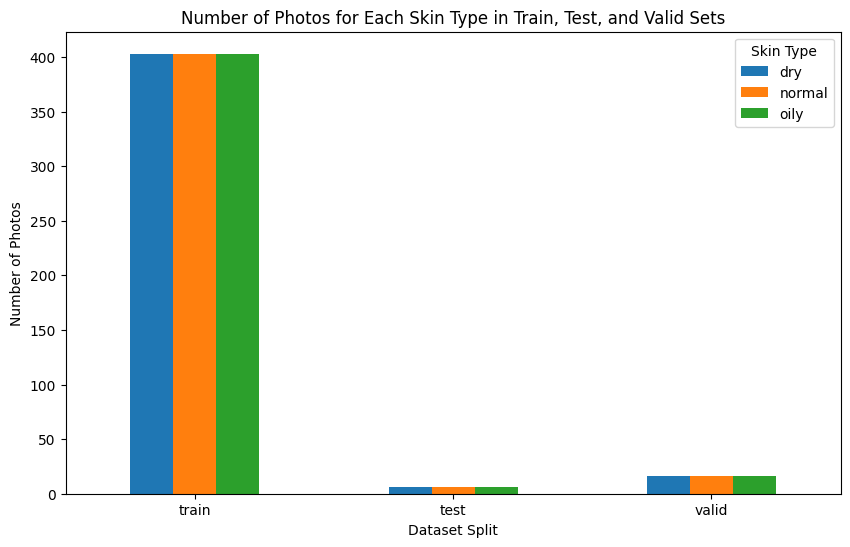

In [10]:
# Initialize dictionaries to store counts of file paths
counts = {'train': {skin_type: 0 for skin_type in skin_types},
          'test': {skin_type: 0 for skin_type in skin_types},
          'valid': {skin_type: 0 for skin_type in skin_types}}

# Iterate over each skin type
for skin_type in skin_types:
    # Define the path to the folder containing images of the current skin type for train, test, and valid sets
    train_path = os.path.join(folder_path, 'train', skin_type)
    test_path = os.path.join(folder_path, 'test', skin_type)
    val_path = os.path.join(folder_path, 'valid', skin_type)

    # Count file paths and store in counts dictionary
    counts['train'][skin_type] = len(os.listdir(train_path))
    counts['test'][skin_type] = len(os.listdir(test_path))
    counts['valid'][skin_type] = len(os.listdir(val_path))

# Create a DataFrame for displaying counts
df_counts = pd.DataFrame(counts).T

# Plot the bar graph
df_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Photos for Each Skin Type in Train, Test, and Valid Sets')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Photos')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.legend(title='Skin Type')
plt.show()

### Encoding label (One-Hot Encoded)

In [11]:
# Encode the labels as integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

## Prepare data

In [12]:
# Data generators with augmentation for training set
train_datagen = ImageDataGenerator(
    # preprocessing_function=preprocess_input,
    rotation_range=20,  # Increased rotation range
    width_shift_range=0.4,  # Increased width shift range
    height_shift_range=0.4,  # Increased height shift range
    shear_range=0.4,  # Increased shear range
    zoom_range=0.4,  # Increased zoom range
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],  # Brightness adjustment
    channel_shift_range=50,  # Channel shift
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data generator flows
train_generator = train_datagen.flow_from_directory(
    os.path.join(folder_path, 'train'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(folder_path, 'valid'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(folder_path, 'test'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 1209 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Found 18 images belonging to 3 classes.


## Image Augmentation


In [26]:
# Define some hyperparameters
batch_size = 16
epochs = 50

In [27]:
# Model architecture with increased dropout rates
base_model = MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

# weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
# weights_file = "inception_v3.h5"
# urllib.request.urlretrieve(weights_url, weights_file)
# base_model.load_weights(weights_file)

base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(32, kernel_regularizer = tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001), activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(len(skin_types), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0015),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# # Callbacks with more aggressive learning rate reduction
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.00001)

## Model Training

In [28]:
num_output = len(skin_types)
print(num_output)

3


In [29]:
# Train the model
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = epochs
)

Epoch 1/50
76/76 [==============================] - 32s 356ms/step - loss: 1.3045 - accuracy: 0.3664 - val_loss: 1.1183 - val_accuracy: 0.4583
Epoch 2/50
76/76 [==============================] - 25s 335ms/step - loss: 1.1370 - accuracy: 0.3854 - val_loss: 1.0993 - val_accuracy: 0.5417
Epoch 3/50
76/76 [==============================] - 26s 340ms/step - loss: 1.1096 - accuracy: 0.4351 - val_loss: 1.0874 - val_accuracy: 0.4792
Epoch 4/50
76/76 [==============================] - 26s 342ms/step - loss: 1.0717 - accuracy: 0.4814 - val_loss: 1.0313 - val_accuracy: 0.5417
Epoch 5/50
76/76 [==============================] - 31s 414ms/step - loss: 1.0504 - accuracy: 0.5070 - val_loss: 1.0397 - val_accuracy: 0.5208
Epoch 6/50
76/76 [==============================] - 25s 335ms/step - loss: 1.0423 - accuracy: 0.4872 - val_loss: 1.0352 - val_accuracy: 0.5417
Epoch 7/50
76/76 [==============================] - 27s 356ms/step - loss: 1.0186 - accuracy: 0.4855 - val_loss: 0.9905 - val_accuracy: 0.6250

In [30]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# Save the model
model.save('/tmp/skin_type_model.h5')

2/2 [==============================] - 0s 16ms/step - loss: 1.1178 - accuracy: 0.5000
Test Accuracy: 0.5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


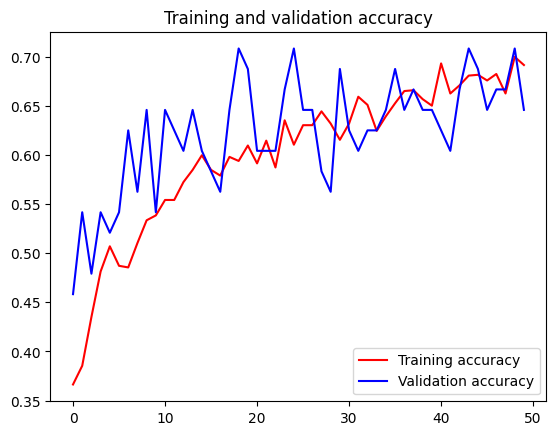

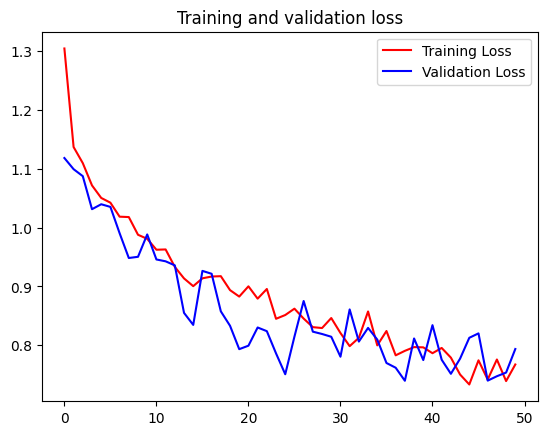

In [31]:
# Plot the chart for accuracy and loss on both training and validation
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

#Model Prediction Result on Test Set

3/3 [==============================] - 0s 83ms/step - loss: 0.7936 - accuracy: 0.6458
Validation Loss: 0.7935662269592285
Validation Accuracy: 0.6458333134651184
2/2 [==============================] - 0s 17ms/step - loss: 1.1178 - accuracy: 0.5000
Test Loss: 1.1177988052368164
Test Accuracy: 0.5
2/2 [==============================] - 1s 23ms/step
Classification Report:
               precision    recall  f1-score   support

         dry       0.17      0.17      0.17         6
      normal       1.00      0.33      0.50         6
        oily       0.40      0.67      0.50         6

    accuracy                           0.39        18
   macro avg       0.52      0.39      0.39        18
weighted avg       0.52      0.39      0.39        18



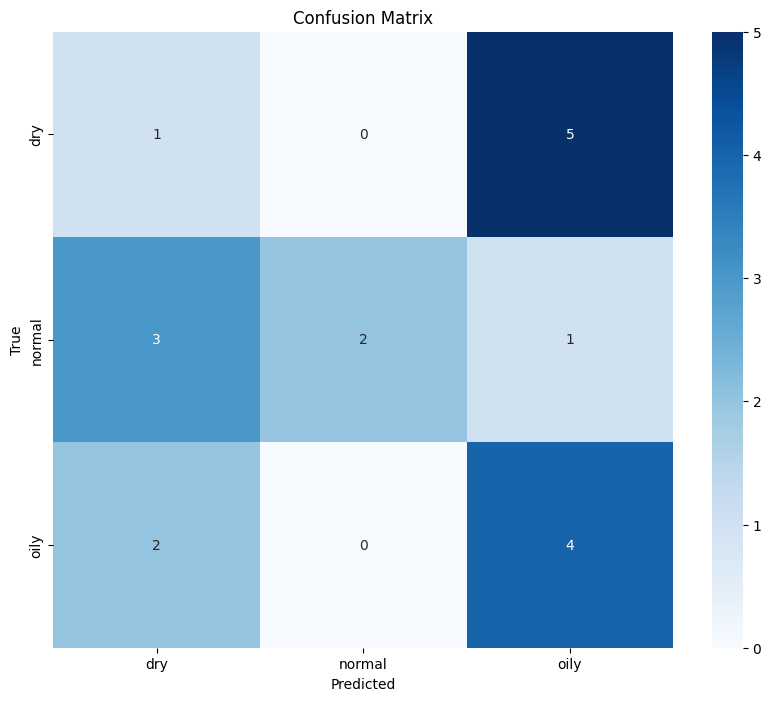

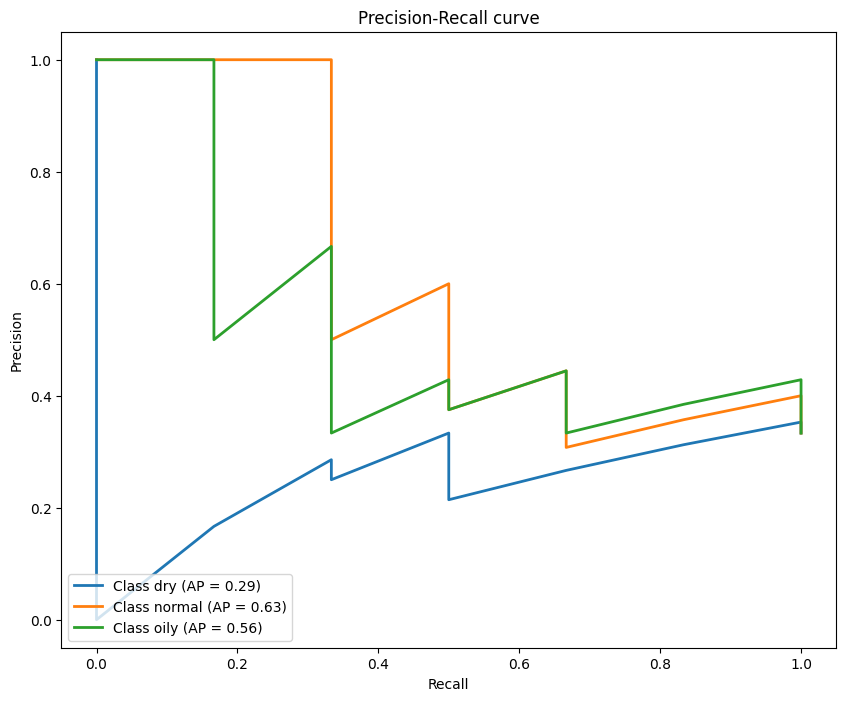

In [32]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Precision-Recall curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(class_labels)):
    precision[i], recall[i], _ = precision_recall_curve(true_classes == i, predictions[:, i])
    average_precision[i] = average_precision_score(true_classes == i, predictions[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {class_labels[i]} (AP = {average_precision[i]:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

no longer used:

In [33]:
# Get the highest probability indices for every test data
highest_prob_indices = np.argmax(predictions, axis=1)

# Inverse transform to get the label name
prediction_labels = label_encoder.inverse_transform(highest_prob_indices)

# Get the true labels of the test data
true_labels = label_encoder.inverse_transform(y_test)

In [34]:
# Show the predicted labels and the corresponding true labels side by side in a dataframe
df_test_results = pd.DataFrame({'True': true_labels, 'Model Prediction': prediction_labels})
df_test_results

,True,Model Prediction
0,dry,oily
1,dry,oily
2,dry,oily
3,dry,dry
4,dry,oily
5,dry,oily
6,normal,normal
7,normal,normal
8,normal,dry
9,normal,oily


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Check the accuracy score on the test set
print('Accuracy:', accuracy_score(true_labels, prediction_labels))

# Check the precision score on the test set
print('Precision:', precision_score(true_labels, prediction_labels, average='weighted'))

# Check the recall score on the test set
print('Recall:', recall_score(true_labels, prediction_labels, average='weighted'))

# Check the f1 score on the test set
print('F1:', f1_score(true_labels, prediction_labels, average='weighted'))

Accuracy: 0.3888888888888889
Precision: 0.5222222222222223
Recall: 0.3888888888888889
F1: 0.3888888888888889


In [36]:
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
confusion_mat = confusion_matrix(true_labels, prediction_labels)

# Get the TP, TN, FP, FN values from the confusion matrix
TP = confusion_mat[1, 1]
TN = confusion_mat[0, 0]
FP = confusion_mat[0, 1]
FN = confusion_mat[1, 0]

# Displays TP, TN, FP, FN values
print("True Positive (TP):", TP)
print("True Negative (TN):", TN)
print("False Positive (FP):", FP)
print("False Negative (FN):", FN)

True Positive (TP): 2
True Negative (TN): 1
False Positive (FP): 0
False Negative (FN): 3


#Load Model

In [37]:
import os
from tensorflow.keras.models import load_model

# H5 format
model.save('/tmp')

In [38]:
# TFLite format
converter = tf.lite.TFLiteConverter.from_saved_model('/tmp')
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert();

import pathlib

tflite_model_file = pathlib.Path('/tmp/skin_type1.tflite')
tflite_model_file.write_bytes(tflite_model)

3577808